# Exercises

In [1]:
import math
import evaluate


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler


from pydataset import data

1. Select a dataset with a continuous target variable.

In [2]:
#Loading tips
swiss_df= data('swiss')

In [3]:
#Looking at docs for tips
data('swiss', show_doc=True)

swiss

PyDataset Documentation (adopted from R Documentation. The displayed examples are in R)

## Swiss Fertility and Socioeconomic Indicators (1888) Data

### Description

Standardized fertility measure and socio-economic indicators for each of 47
French-speaking provinces of Switzerland at about 1888.

### Usage

    data(swiss)

### Format

A data frame with 47 observations on 6 variables, each of which is in percent,
i.e., in [0,100].

[,1] Fertility Ig, "common standardized fertility measure" [,2] Agriculture
[,3] Examination nation [,4] Education [,5] Catholic [,6] Infant.Mortality
live births who live less than 1 year.

All variables but 'Fert' give proportions of the population.

### Source

Project "16P5", pages 549-551 in

Mosteller, F. and Tukey, J. W. (1977) “Data Analysis and Regression: A Second
Course in Statistics”. Addison-Wesley, Reading Mass.

indicating their source as "Data used by permission of Franice van de Walle.
Office of Population Research, Princeton Univer

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [4]:
#Looking at first 5 values
swiss_df.head()

Fertility  Agriculture  Examination  Education  Catholic  \
Courtelary         80.2         17.0           15         12      9.96   
Delemont           83.1         45.1            6          9     84.84   
Franches-Mnt       92.5         39.7            5          5     93.40   
Moutier            85.8         36.5           12          7     33.77   
Neuveville         76.9         43.5           17         15      5.16   

              Infant.Mortality  
Courtelary                22.2  
Delemont                  22.2  
Franches-Mnt              20.2  
Moutier                   20.3  
Neuveville                20.6

In [5]:
#Looking at datatypes
swiss_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47 entries, Courtelary to Rive Gauche
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Fertility         47 non-null     float64
 1   Agriculture       47 non-null     float64
 2   Examination       47 non-null     int64  
 3   Education         47 non-null     int64  
 4   Catholic          47 non-null     float64
 5   Infant.Mortality  47 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 2.6+ KB


In [6]:
swiss_df.isnull().sum()

Fertility           0
Agriculture         0
Examination         0
Education           0
Catholic            0
Infant.Mortality    0
dtype: int64

In [7]:
#split function
def split(df):
    '''
    This function take in the telco data acquired by get_telco_data,
    performs a split and stratifies churn column.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=123)
    return train, validate, test


In [8]:
#using split function
train, validate, test= split(swiss_df)

In [9]:
#Looking at shape for each dataset
train.shape, validate.shape, test.shape

((25, 6), (12, 6), (10, 6))

In [10]:
y_col = 'Fertility'

X_train, y_train = train.drop(columns= ['Fertility']), train[y_col]
X_validate, y_validate = validate.drop(columns= ['Fertility']), validate[y_col]
X_test, y_test = test.drop(columns= ['Fertility']), test[y_col]

In [11]:
numeric_cols= ['Agriculture', 'Examination', 'Education', 'Catholic', 'Infant.Mortality']

In [12]:
#scaling using a function that makes minmax scaler

def min_max_scale(X_train, X_validate, X_test, numeric_cols):
    """
    this function takes in 3 dataframes with the same columns,
    a list of numeric column names (because the scaler can only work with numeric columns),
    and fits a min-max scaler to the first dataframe and transforms all
    3 dataframes using that scaler.
    it returns 3 dataframes with the same column names and scaled values.
    """
    # create the scaler object and fit it to X_train (i.e. identify min and max)
    # if copy = false, inplace row normalization happens and avoids a copy (if the input is already a numpy array).

    scaler = MinMaxScaler(copy=True).fit(X_train[numeric_cols])

    # scale X_train, X_validate, X_test using the mins and maxes stored in the scaler derived from X_train.
    #
    X_train_scaled_array = scaler.transform(X_train[numeric_cols])
    X_validate_scaled_array = scaler.transform(X_validate[numeric_cols])
    X_test_scaled_array = scaler.transform(X_test[numeric_cols])

    # convert arrays to dataframes
    X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=numeric_cols).set_index(
        [X_train.index.values]
    )

    X_validate_scaled = pd.DataFrame(
        X_validate_scaled_array, columns=numeric_cols
    ).set_index([X_validate.index.values])

    X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=numeric_cols).set_index(
        [X_test.index.values]
    )

    return X_train_scaled, X_validate_scaled, X_test_scaled

In [13]:
#Using function
X_train_scaled, X_validate_scaled, X_test_scaled= min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [14]:
#Looking at shapes
X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

((25, 5), (12, 5), (10, 5))

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [15]:
#Using SelectKbest to look at features most correlated with our target (fertility)
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(score_func=f_regression, k=2)
f_selector.fit(X_train_scaled, y_train)

SelectKBest(k=2, score_func=<function f_regression at 0x7ffa6803f8b0>)

In [16]:
mask = f_selector.get_support()
X_train_scaled.columns[mask]

Index(['Examination', 'Catholic'], dtype='object')

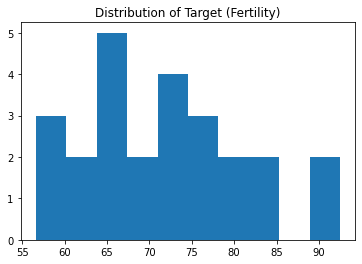

In [17]:
# Is it a normal distribution?
plt.hist(y_train)
plt.title('Distribution of Target (Fertility)')
plt.show()

In [18]:
#Looking at y_train (an array) before turning it into a dataframe
y_train.head()

Rolle      60.5
Lavaux     65.1
Nyone      56.6
Conthey    75.5
Yverdon    65.4
Name: Fertility, dtype: float64

In [19]:
#make it a dataframe
y_train= pd.DataFrame({'actual': y_train})

In [20]:
#Looking to see if actual was added
y_train.head()

actual
Rolle      60.5
Lavaux     65.1
Nyone      56.6
Conthey    75.5
Yverdon    65.4

In [21]:
#Created baseline
baseline= y_train['actual'].mean()

In [22]:
#Making baseline column
y_train['baseline'] = baseline

In [23]:
#Looking to see baseline column was added
y_train.head()

actual  baseline
Rolle      60.5    71.536
Lavaux     65.1    71.536
Nyone      56.6    71.536
Conthey    75.5    71.536
Yverdon    65.4    71.536

In [24]:
#calculate RMSE for baseline model
print('Train RMSE baseline model:')
math.sqrt(mean_squared_error(y_train.actual, y_train.baseline))

Train RMSE baseline model:


9.773714953895475

In [25]:
#OLS regression model 2
model2= LinearRegression()
model2.fit(X_train, y_train.actual)

LinearRegression()

In [26]:
#creating prediction column
y_train['model_2'] = model2.predict(X_train)

In [27]:
#calculate RMSE for model
print('Train RMSE model 2:')
math.sqrt(mean_squared_error(y_train.actual, y_train.model_2))

Train RMSE model 2:


4.571043042889269

In [28]:
#OLS regression model 3

model3= LinearRegression(normalize=True)
model3.fit(X_train, y_train.actual)

LinearRegression(normalize=True)

In [29]:
#creating prediction column
y_train['model_3'] = model3.predict(X_train)

In [30]:
#calculate RMSE for model
print('Train RMSE model 3:')
math.sqrt(mean_squared_error(y_train.actual, y_train.model_3))

Train RMSE model 3:


4.571043042889269